In [154]:
"""
This notebook was inspired from the code project available at [link]
This notebook intends to show the overlapping of the edge detected masks
for the ED and ES frames.
"""

'\nThis notebook was inspired from the code project available at [link]\nThis notebook intends to show the overlapping of the edge detected masks\nfor the ED and ES frames.\n'

In [155]:
import os
import random
import csv
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import ImageOps, Image
from IPython.display import display, HTML
from tensorflow import keras
from tensorflow.keras.layers import Activation, BatchNormalization, Concatenate, Conv2D, Input, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

#display(HTML("<script>.container {width:100% !important; } </style>"))

In [156]:
echonet_dir = Path('../Echonet/')
ed_original_val_dir = echonet_dir / 'Images' / 'Val' / 'EDV' / 'Originals2'
es_original_val_dir = echonet_dir / 'Images' / 'Val' / 'ESV' / 'Originals2'
ed_mask_val_dir = echonet_dir / 'Images' / 'Val' / 'EDV' / 'Masks'
es_mask_val_dir = echonet_dir / 'Images' / 'Val' / 'ESV' / 'Masks'
overlay_dir = echonet_dir / 'Images' / 'Overlays'

In [157]:
# Global variables and paths
test_video_dir = Path('../Notebook/test_video/')
echonet_dir = Path('../Echonet/')
label_trace_path = echonet_dir / 'Labels' / 'VolumeTracings.csv'
file_list_path = echonet_dir / 'Labels' / 'FileList.csv'
weights_edv_path = '../Notebook/weights_EDV.h5'
weights_esv_path = '../Notebook/weights_ESV.h5'


VIDEO_NAME1 = '0X1A030EFDD45062FA.avi'
VIDEO_NAME2 = '0X1A3D565B371DC573.avi'
VIDEO_NAME3 = '0X1A5FAE3F9D37794E.avi'
EXAMPLE_10 = '0X100009310A3BD7FC.avi'
IMG_SIZE = (112,112)


ed_val_original_paths = sorted(
    [
        os.path.join(ed_original_val_dir, fname)
        for fname in os.listdir(ed_original_val_dir)
        if fname.endswith('.png')
    ]
)

es_val_original_paths = sorted(
    [
        os.path.join(es_original_val_dir, fname)
        for fname in os.listdir(es_original_val_dir)
        if fname.endswith('.png')
    ]
)

ed_val_mask_paths = sorted(
    [
        os.path.join(ed_mask_val_dir, fname)
        for fname in os.listdir(ed_mask_val_dir)
        if fname.endswith('.png') and not fname.startswith('.')
    ]
)

es_val_mask_paths = sorted(
    [
        os.path.join(es_mask_val_dir, fname)
        for fname in os.listdir(es_mask_val_dir)
        if fname.endswith('.png') and not fname.startswith('.')
    ]
)



In [158]:
# load video
def load_video(path, filename):
    vpath = (path + "/" + filename)
    print("vpath", vpath)
    if not os.path.exists(vpath):
        raise FileNotFoundError
    cap = cv2.VideoCapture(vpath)

    f_c = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    f_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    f_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    vframes = np.zeros((f_c, f_w, f_h, 3), np.uint8)

    for i in range(f_c):
        ret, frame = cap.read()
        if not ret:
            raise ValueError("")
        vframes[i] = frame

    vframes = vframes.transpose((3, 0, 1, 2))
    print(vframes.shape)
    return vframes, filename




In [159]:
# load .csv data files
def load_filelist_data(path):
    with open(path, newline='') as csvfile:
        print("filelist data loading...")
        header = csvfile.readline().strip().split(',')
        assert header == ["FileName", "EF", "ESV", "EDV",
                          "FrameHeight", "FrameWidth", "FPS",
                          "NumberOfFrames", "Split"]
        print("filelist data loaded.")
        filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        filelist = []
        for row in filereader:
            split_row = row[0].split(',')
            assert (len(split_row) == 9)
            filelist.append(split_row)
        filelist = np.array(filelist)
    csvfile.close()
    return filelist

def load_tracing_data(path, fl):
    print('loading tracing volume data...')
    raw_tracings = []
    tracings = []
    for f in fl[0:-6]:
        vname = [f[0]]
        tracings.append(vname)
    # check filelist [] and tracings [] are the same length
    assert len(tracings) == len(fl[0:-6])

    with open(path, newline='') as csvfile:
        header = csvfile.readline().strip().split(',')
        assert header == ["FileName", "X1", "Y1", "X2", "Y2", "Frame"]
        filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in filereader:
            srow = row[0].split(',')
            # check length of each row is same as the number of...
            # columns defined in header
            assert len(srow) == len(header)
            raw_tracings.append(srow)
    csvfile.close()

    i = 0
    for trace in tracings:
        if i%1000 == 0:
            print(i)
        for raw in raw_tracings[i:]:
            if raw[0] == trace[0]:
                coords = raw[1:6]
                trace.append(coords)
                i += 1
    print("tracings data loaded.")

    return tracings

In [160]:
# load .csv file data
#fldata = load_filelist_data(file_list_path)
#tdata = load_tracing_data(label_trace_path, fldata)

In [161]:
# load video
video_frames, video_name = load_video(str(test_video_dir), EXAMPLE_10)

vpath ../Notebook/test_video/0X100009310A3BD7FC.avi
(3, 174, 112, 112)


In [162]:
# extract ED and ES frames from video frames
def get_cardiac_frames(frames, filename, tracings):
    assert len(tracings) == 10024
    v_tracings = []
    for tracing in tracings:
        if tracing[0] == filename:
            v_tracings.append(tracing)
            break
        else:
            pass
    [v_tracings] = v_tracings

    d_idx = int(v_tracings[1][-1])
    s_idx = int(v_tracings[-1][-1])
    edv = frames[0][d_idx]
    esv = frames[0][s_idx]

    return edv, esv

#edv_frame, esv_frame = get_cardiac_frames(video_frames, video_name, tdata)
#edv_frame = np.expand_dims(edv_frame, 2)
#esv_frame = np.expand_dims(esv_frame, 2)


In [163]:
class EchoGen(keras.utils.Sequence):

    def __init__(self, original_paths, mask_paths, batch_size, img_size):
        self.original_paths = original_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return len(self.mask_paths) // self.batch_size

    def on_epoch_end(self):
        random.Random(1337).shuffle(self.original_paths)
        random.Random(1337).shuffle(self.mask_paths)
        #display_pred(example, val_preds)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_original_paths = self.original_paths[i: i + self.batch_size]
        batch_mask_paths = self.mask_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_original_paths):
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255
            img = img.astype(np.float32)
            x[j] = img
            # plt.imshow(img)
            # plt.show()
            # print(img)

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='float32')
        for j, path in enumerate(batch_mask_paths):
            _img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            _img = cv2.resize(_img, IMG_SIZE)
            _img[_img > 0] = 255
            _img = _img / 255
            _img = _img.astype(np.int32)
            _img = np.expand_dims(_img, 2)
            y[j] = _img
            # plt.imshow(_img)
            # plt.show()
            # print(_img)

        return x, y

ed_gen = EchoGen(ed_val_original_paths, ed_val_mask_paths, batch_size=64, img_size=IMG_SIZE)
es_gen = EchoGen(es_val_original_paths, es_val_mask_paths, batch_size=64, img_size=IMG_SIZE)

In [164]:
# Build unet
def build_unet():
    """
    Function to build a Unet based neural architecture
    Uses pretrained encoder trained on weights from ImageNet
    """
    inputs = Input((112, 112, 3), name='input_image')

    # Pretrained encoder block
    base_encoder = keras.applications.MobileNetV2(input_tensor=inputs,
                                                   weights='imagenet',
                                                   include_top=False,
                                                   alpha=1.0)
    # base_encoder.summary()
    skip_names = ['input_image',
                  'block_1_expand_relu',   # 56x56
                  'block_3_expand_relu',   # 28x28
                  'block_6_expand_relu']   # 14x14

    encoder_output = base_encoder.get_layer('block_13_expand_relu').output # 7x7

    filters = [64, 128, 256, 512]
    x = encoder_output

    for i in range(1, len(filters)+1, 1):
        x_skip = base_encoder.get_layer(skip_names[-i]).output
        x = UpSampling2D((2,2))(x)
        x = Concatenate()([x, x, x_skip])

        x = Conv2D(filters[-i], (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters[-i], (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = Conv2D(1, (1,1), padding='same')(x)
    x = Activation('sigmoid')(x)

    pre_unet_model = Model(inputs, x)

    return pre_unet_model

ed_model = build_unet()
es_model = build_unet()
all_model = build_unet()

/home/samdev/anaconda3/envs/Cardio_Segmentation/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [165]:
# load models with pretrained weights.
# Two models, two sets of weights for optimal perf.
# loads weights
ed_model.load_weights(filepath=weights_edv_path)
es_model.load_weights(filepath=weights_esv_path)
#all_model.load_weights(filepath=weights_all_path)

In [166]:
# predict LV mask for frames
ed_pred = ed_model.predict(ed_gen)
es_pred = es_model.predict(es_gen)



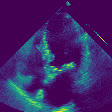

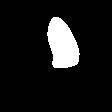

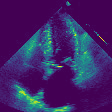

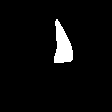

In [230]:
# Parse and display predicitons
def parse_preds(preds):
    """ Convert probabilities into object and background pixel values based on a threshold. """
    _preds = (preds > 0.5).astype(int)
    _preds = _preds * 255
    return _preds


def display_pred(i, preds):
    """ Display predictions. """
    preds = parse_preds(preds)
    mask = preds[i]
    mask = array_to_img(mask)
    display(mask)

EXAMPLE = 0
# Display mask predicted by our model
ed_input_image = cv2.imread(ed_val_original_paths[EXAMPLE], cv2.IMREAD_COLOR)
es_input_image = cv2.imread(es_val_original_paths[EXAMPLE], cv2.IMREAD_COLOR)
ed_input_image = cv2.cvtColor(ed_input_image, cv2.COLOR_BGRA2RGBA)
es_input_image = cv2.cvtColor(es_input_image, cv2.COLOR_BGRA2RGBA)
ed_input_image = array_to_img(ed_input_image)
es_input_image = array_to_img(es_input_image)
display(ed_input_image)
display_pred(EXAMPLE, ed_pred)
display(es_input_image)
display_pred(EXAMPLE, es_pred)


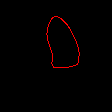

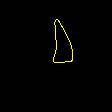

In [207]:
# edge detection on predicted masks
def detect_edges(i, preds, color_tuple):
    """
    function that uses numpy's implementation of the Canny edge detection
    algorithm to detect the borders of the mask
    :param i:
    :param preds:
    :return:
    """
    preds = parse_preds(preds)
    mask = preds[i]
    mask = np.array(mask).astype(np.uint8)
    mask_edges = cv2.Canny(mask, 100, 200)
    rgb_edges = cv2.cvtColor(mask_edges, cv2.COLOR_GRAY2RGB)
    #mask_edges = np.expand_dims(mask_edges, 2)
    rgb_edges *= np.array(color_tuple, np.uint8)

    return rgb_edges


ed_edge = detect_edges(0, ed_pred, (1,0,0))
display(array_to_img(ed_edge))
es_edge = detect_edges(0, es_pred, (1,1,0))
display(array_to_img(es_edge))
resize_ed_edge = cv2.resize(ed_edge, (18,18))
#print('resize_ed_edge: \n', resize_ed_edge)

(112, 112, 3)
(112, 112, 3)


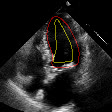

In [209]:
def overlay_edges(underlay, edge1, edge2):
    print(underlay.shape)
    #print(edge1.shape)
    #overlay = underlay + edge1 + edge2

    overlay = cv2.addWeighted(underlay, 1, edge1, 0.5, 0)
    overlay = cv2.addWeighted(overlay, 1, edge2, 0.5, 0)

    #plt.imshow(underlay)
    #plt.imshow(edge1)
    #plt.imshow(edge2)
    #plt.imshow(ed_mask)
    #plt.show()
    print(underlay.shape)

    return overlay

ed_input = cv2.imread('../Notebook/test_video/' + video_name + 'edv_frame.png', cv2.IMREAD_COLOR)
edges = overlay_edges(ed_input, ed_edge, es_edge)
cv2.imwrite('../Notebook/edge_edv_frame.png', edges)
#edges = cv2.resize(edges, (18,18))
#print(edges)
display(array_to_img(edges))

#cv2.imwrite('../Notebook/test_video/edge_edv_frame.png', ed_edge)
#cv2.imwrite('../Notebook/test_video/edge_esv_frame.png', es_edge)

























